In [2]:
import sys
sys.path.append("../Code")

In [48]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [75]:
data = loadmat('/home/ning/devel/Machine_learning_dynamics/data/phase_field_oneD_simulation_beginning_stage.mat')

In [76]:
num_data_train = 50000

In [77]:
x = np.squeeze(data['x'])
t = np.squeeze(data['t'])
phi = data['usol']
del data

In [78]:
phi_x, phi_t = np.gradient(phi,x[1]-x[0],t[1]-t[0])

In [79]:
phi_xx, _ = np.gradient(phi_x,x[1]-x[0],t[1]-t[0])

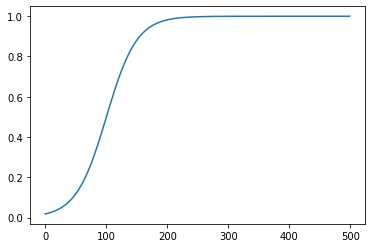

In [80]:
plt.plot(phi[:,0])

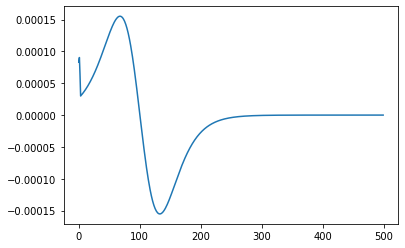

In [81]:
plt.plot(phi_xx[:,0])

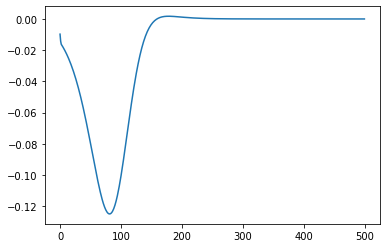

In [82]:
plt.plot(phi_t[:,0])

In [83]:
np.random.seed(111)

In [84]:
phi = np.reshape(phi,(-1,))
phi_t = np.reshape(phi_t, (-1,))
phi_xx = np.reshape(phi_xx, (-1,))

In [85]:
mean_phi = np.mean(phi)
phi -= mean_phi
mean_phi_t = np.mean(phi_t)
phi_t -= mean_phi_t
mean_phi_xx = np.mean(phi_xx)
phi_xx -= mean_phi_xx
std_phi = np.std(phi)
std_phi_xx = np.std(phi_xx)
std_phi_t = np.std(phi_t)

In [86]:
phi /= std_phi
phi_xx /= std_phi_xx
phi_t /= std_phi_t

In [87]:
gamma=1.
m=-0.4
ypsilon=10. 
#phi = np.random.normal(size=1000)
#phi_xx = np.random.normal(size=1000)
#phi_t_direct = ypsilon * phi_xx - gamma*phi*(1.-phi)*(0.5-phi) + m*phi*(1.-phi)

In [88]:
phi_t_direct = ypsilon * phi_xx - gamma*phi*(1.-phi)*(0.5-phi) + m*phi*(1.-phi)

In [89]:
indices = np.arange(len(phi))

In [90]:
np.random.shuffle(indices)

In [91]:
indices_train = indices[:num_data_train]

In [92]:
phi = phi[indices_train]
phi_t = phi_t[indices_train]
phi_xx = phi_xx[indices_train]
#phi_t_direct = phi_t_direct[indices_train]

In [4]:
from S_snap import integerSnap

In [93]:
datafile = 'phase_field_OneD'

In [94]:
np.savetxt(datafile, np.column_stack((phi,phi_xx, phi_t)))

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path
from get_pareto import Point, ParetoSet
from RPN_to_pytorch import RPN_to_pytorch
from RPN_to_eq import RPN_to_eq
from S_NN_train import NN_train
from S_NN_eval import NN_eval
from S_symmetry import *
from S_separability import *
from S_change_output import *
from S_brute_force import brute_force
from S_combine_pareto import combine_pareto
from S_get_number_DL import get_number_DL
from sympy.parsing.sympy_parser import parse_expr
from sympy import preorder_traversal, count_ops
from S_polyfit import polyfit
from S_get_symbolic_expr_error import get_symbolic_expr_error
from S_add_snap_expr_on_pareto import add_snap_expr_on_pareto
from S_add_sym_on_pareto import add_sym_on_pareto
from S_run_bf_polyfit import run_bf_polyfit
from S_final_gd import final_gd
from S_add_bf_on_numbers_on_pareto import add_bf_on_numbers_on_pareto
from dimensionalAnalysis import dimensionalAnalysis

In [131]:
pathdir = './'
filename = datafile
polyfit_deg = 5
test_percentage = 20

In [132]:
# Split the data into train and test set 
input_data = np.loadtxt(pathdir+filename)
sep_idx = np.random.permutation(len(input_data))
train_data = input_data[sep_idx[0:(100-test_percentage)*len(input_data)//100]]
test_data = input_data[sep_idx[test_percentage*len(input_data)//100:len(input_data)]]


In [133]:
np.savetxt(pathdir+filename+"_train",train_data)
if test_data.size != 0:
    np.savetxt(pathdir+filename+"_test",test_data)


In [134]:
PA = ParetoSet()

In [135]:
filename_train = filename+"_train"

In [136]:
import numpy as np
import os
from S_polyfit_utils import getBest
from S_polyfit_utils import basis_vector
import itertools
import sys
import csv
import sympy
from sympy import symbols, Add, Mul, S, simplify
from scipy.linalg import fractional_matrix_power

def mk_sympy_function(coeffs, num_covariates, deg):
    generators = [basis_vector(num_covariates+1, i) for i in range(num_covariates+1)]
    powers = map(sum, itertools.combinations_with_replacement(generators, deg))
    
    coeffs = np.round(coeffs,2)
    
    xs = (S.One,) + symbols('z0:%d'%num_covariates)
    if len(coeffs)>1:
        return Add(*[coeff * Mul(*[x**deg for x, deg in zip(xs, power)])
                     for power, coeff in zip(powers, coeffs)])
    else:
        return coeffs[0]

def polyfit(maxdeg, filename):
    n_variables = np.loadtxt(filename, dtype='str').shape[1]-1
    variables = np.loadtxt(filename, usecols=(0,))
    means = [np.mean(variables)]

    for j in range(1,n_variables):
        v = np.loadtxt(filename, usecols=(j,))
        means = means + [np.mean(v)]
        variables = np.column_stack((variables,v))
       
    f_dependent = np.loadtxt(filename, usecols=(n_variables,))

    if n_variables>1:
        C_1_2 = fractional_matrix_power(np.cov(variables.T),-1/2)
        x = []
        z = []
        for ii in range(len(variables[0])):
            variables[:,ii] = variables[:,ii] - np.mean(variables[:,ii])
            x = x + ["x"+str(ii)]
            z = z + ["z"+str(ii)]

        variables = np.matmul(C_1_2,variables.T).T
        res = getBest(variables,f_dependent,maxdeg)
        parameters = res[0]
        params_error = res[1]
        deg = res[2]
        
        x = sympy.Matrix(x)
        M = sympy.Matrix(C_1_2)
        b = sympy.Matrix(means)
        M_x = M*(x-b)

        eq = mk_sympy_function(parameters,n_variables,deg)
        symb = sympy.Matrix(z)

        for i in range(len(symb)):
            eq = eq.subs(symb[i],M_x[i])

        eq = simplify(eq)
        
    else:
        res = getBest(variables,f_dependent,maxdeg)
        parameters = res[0]
        params_error = res[1]
        deg = res[2]
        eq = mk_sympy_function(parameters,n_variables,deg)
        try:
            eq = eq.subs("z0","x0")  
        except:
            pass

    return (eq, params_error)

In [153]:
# run polyfit on the data
print("Checking polyfit \n")
polyfit_result = polyfit(polyfit_deg, filename_train)

Checking polyfit 



In [154]:
polyfit_result

(-2.64914622753371*x0**3 + 0.00250556498824661*x0**2*x1 - 2.06516036561274*x0**2 + 0.00618459242250563*x0*x1**2 + 0.00744403399499871*x0*x1 + 4.27454044181517*x0 + 0.0053493709875092*x1**3 + 0.00326983750029387*x1**2 + 0.134241836467056*x1 - 0.830552886705462,
 0.385700768580379)

In [155]:
eqn = str(polyfit_result[0])
# Calculate the complexity of the polyfit expression the same way as for gradient descent case    

In [156]:
eqn

'-2.64914622753371*x0**3 + 0.00250556498824661*x0**2*x1 - 2.06516036561274*x0**2 + 0.00618459242250563*x0*x1**2 + 0.00744403399499871*x0*x1 + 4.27454044181517*x0 + 0.0053493709875092*x1**3 + 0.00326983750029387*x1**2 + 0.134241836467056*x1 - 0.830552886705462'

In [157]:
polyfit_err = get_symbolic_expr_error(pathdir,filename,eqn)
expr = parse_expr(eqn)
is_atomic_number = lambda expr: expr.is_Atom and expr.is_number
numbers_expr = [subexpression for subexpression in preorder_traversal(expr) if is_atomic_number(subexpression)]
complexity = 0
for j in numbers_expr:
    complexity = complexity + get_number_DL(float(j))
try:
    # Add the complexity due to symbols
    n_variables = len(polyfit_result[0].free_symbols)
    n_operations = len(count_ops(polyfit_result[0],visual=True).free_symbols)
    if n_operations!=0 or n_variables!=0:
        complexity = complexity + (n_variables+n_operations)*np.log2((n_variables+n_operations))
except:
    pass

In [159]:
from S_add_snap_expr_on_pareto_polyfit import add_snap_expr_on_pareto_polyfit

In [162]:
#run zero snap on polyfit output
PA_poly = ParetoSet()
PA_poly.add(Point(x=complexity, y=polyfit_err, data=str(eqn)))
PA_poly = add_snap_expr_on_pareto_polyfit(pathdir, filename_train, str(eqn), PA_poly)    

In [ ]:
    
for l in range(len(PA_poly.get_pareto_points())):
    PA.add(Point(PA_poly.get_pareto_points()[l][0],PA_poly.get_pareto_points()[l][1],PA_poly.get_pareto_points()[l][2]))

In [143]:
print("Complexity  RMSE  Expression")
for pareto_i in range(len(PA.get_pareto_points())):
    print(PA.get_pareto_points()[pareto_i])

Complexity  RMSE  Expression
[18.491853096329674, 1.1762453280363372, '-3*x0**3 - 2*x0**2 + 4*x0 - 1']
[64.4043739045174, 0.347168871588419, '-2.64914622753371*x0**3 - 2*x0**2 + 4*x0 - 1']
[110.68520846145448, 0.16754423424857953, '-2.64914622753371*x0**3 - 2*x0**2 + 4.27454044181517*x0 - 1']
[155.92434573188154, 0.1443373255987311, '-2.64914622753371*x0**3 - 2*x0**2 + 4.27454044181517*x0 - 0.830552886705462']
[207.04402032725395, 0.09433218646002055, '-2.64914622753371*x0**3 - 2*x0**2 + 4.27454044181517*x0 + 0.134241836467056*x1 - 0.830552886705462']
[253.0123049703494, 0.007594253239133429, '-2.64914622753371*x0**3 - 2.06516036561274*x0**2 + 4.27454044181517*x0 + 0.134241836467056*x1 - 0.830552886705462']


In [144]:
from sympy import symbols, simplify

In [145]:
phi,phi_xx, phi_t = symbols('phi phi_xx phi_t')

In [146]:
x0, x1, y = symbols('x0, x1, y')

In [147]:
phi = x0*std_phi + mean_phi
phi_xx = x1*std_phi_xx + mean_phi_xx

In [148]:
phi_t = ypsilon * phi_xx-gamma*phi*(1-phi)*(0.5-phi) + m*phi*(1-phi) 

In [149]:
phi_t

0.00333027606892688*x1 - (0.261029342035853 - 0.408685630132656*x0)*(-0.408685630132656*x0 - 0.238970657964147)*(0.408685630132656*x0 + 0.738970657964147) + (0.261029342035853 - 0.408685630132656*x0)*(-0.163474252053062*x0 - 0.295588263185659) - 3.58963577638631e-7

In [150]:
simplify(phi_t)

-0.0682602859140573*x0**3 - 0.0529318878681015*x0**2 + 0.110286106040299*x0 + 0.00333027606892688*x1 - 0.0310617958034037

In [151]:
y = (phi_t - mean_phi_t) / std_phi_t

In [152]:
simplify(y)

-2.64236538783377*x0**3 - 2.04900091674779*x0**2 + 4.26919086929635*x0 + 0.128915460851466*x1 - 0.837354388525304